<a href="https://colab.research.google.com/github/bcjuang/learning-representations/blob/main/mnist_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Image Representations for Image Classification

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load MNIST dataset

In [94]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5), (0.5))])

trainset = datasets.MNIST(root='/content/gdrive/MyDrive/bcj_projects/mnist', train=True,
                            download=False, transform=trans)
testset = datasets.MNIST(root='/content/gdrive/MyDrive/bcj_projects/mnist', train=False,
                           download=False, transform=trans)

In [95]:
from torch.utils.data import DataLoader

In [96]:
batch_size = 64
trainloader = DataLoader(trainset, batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size, shuffle=False)

## Build CONV autoencoder for representation learning

In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, bias=False), # b, 32, 28, 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # b, 32, 14, 14
            nn.Conv2d(32, 64, 3, padding=1, bias=False), # b, 64, 14, 14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # b, 64, 7, 7
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1, bias=False), # b, 64, 14, 14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False), # b, 32, 28, 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1, bias=False), # b, 1, 28, 28
            nn.Tanh(),
        )
    
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [16]:
model = Autoencoder().to(device)

In [17]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,432
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
   ConvTranspose2d-9           [-1, 64, 14, 14]          65,536
      BatchNorm2d-10           [-1, 64, 14, 14]             128
             ReLU-11           [-1, 64, 14, 14]               0
  ConvTranspose2d-12           [-1, 32, 28, 28]          32,768
      BatchNorm2d-13           [-1, 32, 28, 28]              64
             ReLU-14           [-1, 32,

In [18]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=1e-4)

In [19]:
EPOCHS = 20
# OneCycleLR min_lr = init_lr (defined in optimizer) / final_div_factor (default: 1e4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
                                                steps_per_epoch=len(trainset), epochs=EPOCHS)
train_loss = []
val_loss = []
for epoch in range(EPOCHS):
    model.train()
    for i, (imgs, labels) in enumerate(trainloader):
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, imgs)
        loss.backward()
        optimizer.step()
        scheduler.step()
        # if (i+1) % 100 == 0:
        #     print(f'\tStep: {i+1} | Train Loss: {loss.item():.3f}')
    train_loss.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, imgs)
    val_loss.append(loss.item())
    print(f'Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss[-1]:.3f} | Val Loss: {val_loss[-1]:.3f}')

Epoch [1/20] | Train Loss: 0.011 | Val Loss: 0.008
Epoch [2/20] | Train Loss: 0.006 | Val Loss: 0.006
Epoch [3/20] | Train Loss: 0.005 | Val Loss: 0.005
Epoch [4/20] | Train Loss: 0.004 | Val Loss: 0.004
Epoch [5/20] | Train Loss: 0.004 | Val Loss: 0.004
Epoch [6/20] | Train Loss: 0.004 | Val Loss: 0.003
Epoch [7/20] | Train Loss: 0.003 | Val Loss: 0.003
Epoch [8/20] | Train Loss: 0.003 | Val Loss: 0.003
Epoch [9/20] | Train Loss: 0.003 | Val Loss: 0.003
Epoch [10/20] | Train Loss: 0.003 | Val Loss: 0.003
Epoch [11/20] | Train Loss: 0.003 | Val Loss: 0.002
Epoch [12/20] | Train Loss: 0.003 | Val Loss: 0.002
Epoch [13/20] | Train Loss: 0.002 | Val Loss: 0.002
Epoch [14/20] | Train Loss: 0.003 | Val Loss: 0.002
Epoch [15/20] | Train Loss: 0.002 | Val Loss: 0.002
Epoch [16/20] | Train Loss: 0.002 | Val Loss: 0.002
Epoch [17/20] | Train Loss: 0.002 | Val Loss: 0.002
Epoch [18/20] | Train Loss: 0.002 | Val Loss: 0.002
Epoch [19/20] | Train Loss: 0.002 | Val Loss: 0.002
Epoch [20/20] | Train

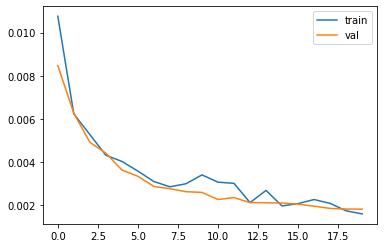

In [20]:
plt.plot(np.arange(EPOCHS), train_loss, label='train')
plt.plot(np.arange(EPOCHS), val_loss, label='val')
plt.legend()

## Image reconstruction

In [31]:
im = next(iter(testloader))
test_img = im[0][:1]

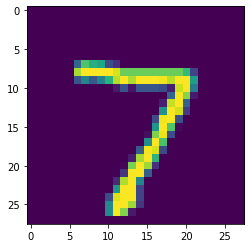

In [34]:
plt.imshow(test_img.squeeze())

In [35]:
test_img = test_img.to(device)
enc_output = model(test_img)

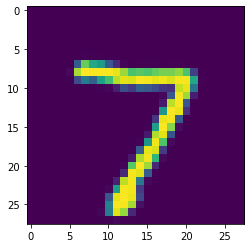

In [37]:
plt.imshow(enc_output.squeeze().cpu().detach())

## Visualize the image representations via t-SNE

In [38]:
from sklearn.manifold import TSNE

In [39]:
tsne = TSNE(n_components=2, random_state=0)

In [81]:
test_imgs = [trans(np.expand_dims(im, -1)) for im in testset.data.numpy()[:1000]]
test_imgs = torch.stack(test_imgs)
test_imgs = test_imgs.to(device)
test_labels = testset.targets[:1000].numpy()

In [82]:
enc_outputs = model.encoder(test_imgs)

In [83]:
enc_outputs = enc_outputs.squeeze().view(test_imgs.size(0), -1).cpu().detach().numpy()

In [84]:
def tsne_plot(emb_data, labels, colors=None):
    colors = colors if colors else sns.color_palette()
    tsne_model = TSNE(n_components=2, init='pca', n_iter=2500, random_state=100)
    new_values = tsne_model.fit_transform(emb_data)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(12, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], color=colors[labels[i]])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     fontsize=12, 
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

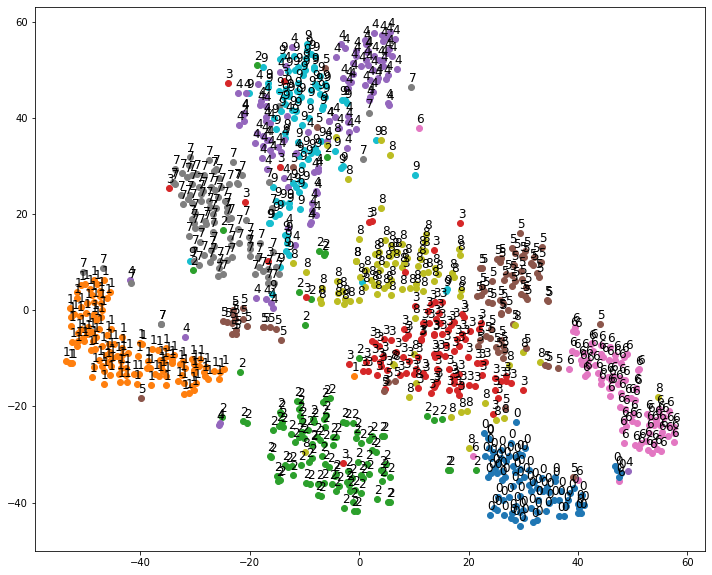

In [85]:
tsne_plot(enc_outputs, test_labels)

## Use the pretrained encoder for image classificaiton

In [97]:
import copy

In [98]:
encoder_ptr = copy.deepcopy(model.encoder)

for param in encoder_ptr.parameters():
    param.requires_grad = False

In [100]:
class Classifier(nn.Module):
    def __init__(self, feature_extractor, nclasses=10):
        super().__init__()
        self.features = feature_extractor
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 32),
            nn.ReLU(),
            nn.Linear(32, nclasses)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        out = self.classifier(x)
        return out

In [101]:
cls_model = Classifier(encoder_ptr, 10)
cls_model.to(device)

Classifier(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [102]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cls_model.parameters(), lr=0.1, weight_decay=1e-4)

In [103]:
EPOCHS = 20
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
                                                steps_per_epoch=len(trainset), epochs=EPOCHS,)

train_loss = []
val_loss = []
for epoch in range(EPOCHS):

    cls_model.train()
    for imgs, labels in trainloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = cls_model(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
    train_loss.append(loss.item())
    
    total = 0
    correct = 0
    cls_model.eval()
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = cls_model(imgs)
            loss = loss_fn(outputs, labels)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    val_loss.append(loss.item())

    print(f'Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss[-1]:.3f} | Val Loss: {val_loss[-1]:.3f} | Val Accuracy: {correct/total:.3f}')

Epoch [1/20] | Train Loss: 0.077 | Val Loss: 0.040 | Val Accuracy: 0.951
Epoch [2/20] | Train Loss: 0.144 | Val Loss: 0.009 | Val Accuracy: 0.970
Epoch [3/20] | Train Loss: 0.103 | Val Loss: 0.014 | Val Accuracy: 0.973
Epoch [4/20] | Train Loss: 0.122 | Val Loss: 0.005 | Val Accuracy: 0.973
Epoch [5/20] | Train Loss: 0.149 | Val Loss: 0.005 | Val Accuracy: 0.972
Epoch [6/20] | Train Loss: 0.149 | Val Loss: 0.014 | Val Accuracy: 0.978
Epoch [7/20] | Train Loss: 0.003 | Val Loss: 0.007 | Val Accuracy: 0.979
Epoch [8/20] | Train Loss: 0.114 | Val Loss: 0.002 | Val Accuracy: 0.974
Epoch [9/20] | Train Loss: 0.005 | Val Loss: 0.001 | Val Accuracy: 0.982
Epoch [10/20] | Train Loss: 0.012 | Val Loss: 0.006 | Val Accuracy: 0.980
Epoch [11/20] | Train Loss: 0.002 | Val Loss: 0.001 | Val Accuracy: 0.982
Epoch [12/20] | Train Loss: 0.013 | Val Loss: 0.001 | Val Accuracy: 0.980
Epoch [13/20] | Train Loss: 0.003 | Val Loss: 0.001 | Val Accuracy: 0.983
Epoch [14/20] | Train Loss: 0.055 | Val Loss: 0